In [1]:
import numpy as np
from pathlib import Path
from src.scripts.plot_gps import load_gps_data, plot_gps_data, save_gps_fig

In [2]:
path = Path('/dataset/Trip066/gnss50_vehicle.bin')
ts, gps_coords = load_gps_data(path)
gps_coords

array([[63.41962151, 10.40174786, 86.5       ],
       [63.4196215 , 10.40174788, 86.5       ],
       [63.41962151, 10.40174784, 86.5       ],
       ...,
       [63.41961699, 10.40174048, 86.5       ],
       [63.41961699, 10.40174048, 86.5       ],
       [63.41961701, 10.40174048, 86.5       ]])

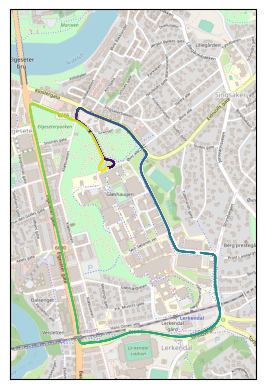

In [3]:
fig, world_coords, px_q = plot_gps_data(ts, gps_coords)
save_gps_fig(fig, 'fig.png')
px_q = dict(px_q)

In [4]:
# Transform to NED and Carla coordinates
import pymap3d
alt = 0
gps_origin = np.mean(gps_coords, axis=0)[:2]
N, E, D = pymap3d.geodetic2ned(gps_coords[:, 0], gps_coords[:, 1], alt, *gps_origin, alt)

carla_lat = N / 111324.60662786
carla_lon = E / 111319.490945

# carla_origin = (0, 0, 0)
# carla_lat, carla_lon, _ = pymap3d.ned2geodetic(N, E, alt, *carla_origin)
# carla_N = carla_lat * 111324.60662786
# carla_E = carla_lon * 111319.490945
# err_n=N-carla_N
# err_e=E-carla_E
# print('Maximum NS error:', np.abs(err_n).max())
# print('Maximum EW error:', np.abs(err_e).max())

# corr_n = np.mean(carla_N / N)
# corr_e = np.mean(carla_E / E)
# print('Correction coefficients:', corr_n, corr_e)
# carla_lat /= corr_n
# carla_lon /= corr_e
# carla_N = carla_lat * 111324.60662786
# carla_E = carla_lon * 111319.490945
# err_n=N-carla_N
# err_e=E-carla_E
# print('Maximum NS error:', np.abs(err_n).max())
# print('Maximum EW error:', np.abs(err_e).max())

In [5]:
from PIL import Image
image = Image.open('plan.png')
px_coords = px_q[image.size]

In [6]:
data = np.array(image)
pink = np.transpose(np.where(np.all(data == (255, 0, 255, 255), axis=-1)))

In [7]:
def find_clusters(points):
    points = set(map(tuple, points))
    clusters = []
    while points:
        point = y, x = points.pop()
        neighbors = [
            (y + i, x + j)
            for i in [-1, 0, 1]
            for j in [-1, 0, 1]
        ]
        
        matching_clusters = []
        for cluster in clusters:
            for neighbor in neighbors:
                if neighbor in cluster:
                    matching_clusters.append(cluster)
                    break
        
        if not matching_clusters:
            clusters.append({ point })
        else:
            main, *to_merge = matching_clusters
            main.add(point)
            for other in to_merge:
                main.update(other)
                other.clear()
            if to_merge:
                clusters = list(filter(None, clusters))
    
    return [np.array(list(cluster)) for cluster in clusters]

pink_clusters = find_clusters(pink)

pink_centers = []
for cluster in pink_clusters:
    y, x = np.mean(cluster, axis=0)
    pink_centers.append((x, y))

In [8]:
iplan = sorted([
    np.argmin(np.sqrt(((px_coords - wp) ** 2).sum(axis=1)))
    for wp in pink_centers
])
iplan.insert(0, 0)
iplan.append(len(px_coords) - 2)

In [9]:
# Fill inn with waypoints every 50 meters
import itertools
# print(iplan)
NE = np.vstack((N, E)).T
# print('NE', NE.shape)
NE_diff = NE[1:] - NE[:-1]
# print('NE_diff', NE_diff.shape)
NE_distances = np.linalg.norm(NE_diff, axis=1)
# print('NE_dist', NE_distances.shape)
cum_distances = np.cumsum(NE_distances)
# print('cum_dist', cum_distances[iplan])
distances = cum_distances[iplan[1:]] - cum_distances[iplan[:-1]]
# print('dist', distances)
missing_wps = (distances // 50).astype(int)
print(missing_wps)
for num, dist, idx, i in reversed(list(zip(missing_wps, distances, iplan, itertools.count()))):
    if not num:
        continue
    spacing = dist / (num + 1)
    print(f'insert {num} after i={i}, idx={idx} with spacing {spacing:.2f}')
    cur_dist = 0
    prev_cur_dist = 0
    for j in range(num):
        while cur_dist < (j+1) * spacing and idx + 1 < NE.shape[0]:
            cur_dist += NE_distances[idx]
            idx += 1
        print(f'  - found point at {idx} dist {cur_dist - prev_cur_dist:.2f}')
        iplan.insert(i+1, idx)
        i += 1
        prev_cur_dist = cur_dist


# Check if it worked
vectors = NE[iplan[1:]] - NE[iplan[:-1]]
distances = np.linalg.norm(vectors, axis=1)
distances[distances > 50]

[0 0 1 2 1 1 3 4 3 5 3 3 2 5 5 2 5 6 2 3 1 2 3 1 3 1 0 0 0]
insert 1 after i=25, idx=5026 with spacing 26.19
  - found point at 5068 dist 26.57
insert 3 after i=24, idx=4891 with spacing 39.75
  - found point at 4932 dist 55.07
  - found point at 4950 dist 24.93
  - found point at 4987 dist 40.12
insert 1 after i=23, idx=4828 with spacing 25.88
  - found point at 4863 dist 26.10
insert 3 after i=22, idx=4623 with spacing 39.11
  - found point at 4659 dist 39.71
  - found point at 4695 dist 38.59
  - found point at 4748 dist 39.23
insert 2 after i=21, idx=4473 with spacing 36.49
  - found point at 4516 dist 36.84
  - found point at 4577 dist 36.43
insert 1 after i=20, idx=4370 with spacing 44.27
  - found point at 4420 dist 44.97
insert 3 after i=19, idx=4218 with spacing 39.66
  - found point at 4253 dist 40.27
  - found point at 4289 dist 39.24
  - found point at 4331 dist 40.41
insert 2 after i=18, idx=4110 with spacing 42.95
  - found point at 4146 dist 43.55
  - found point at 4182

array([54.56847575])

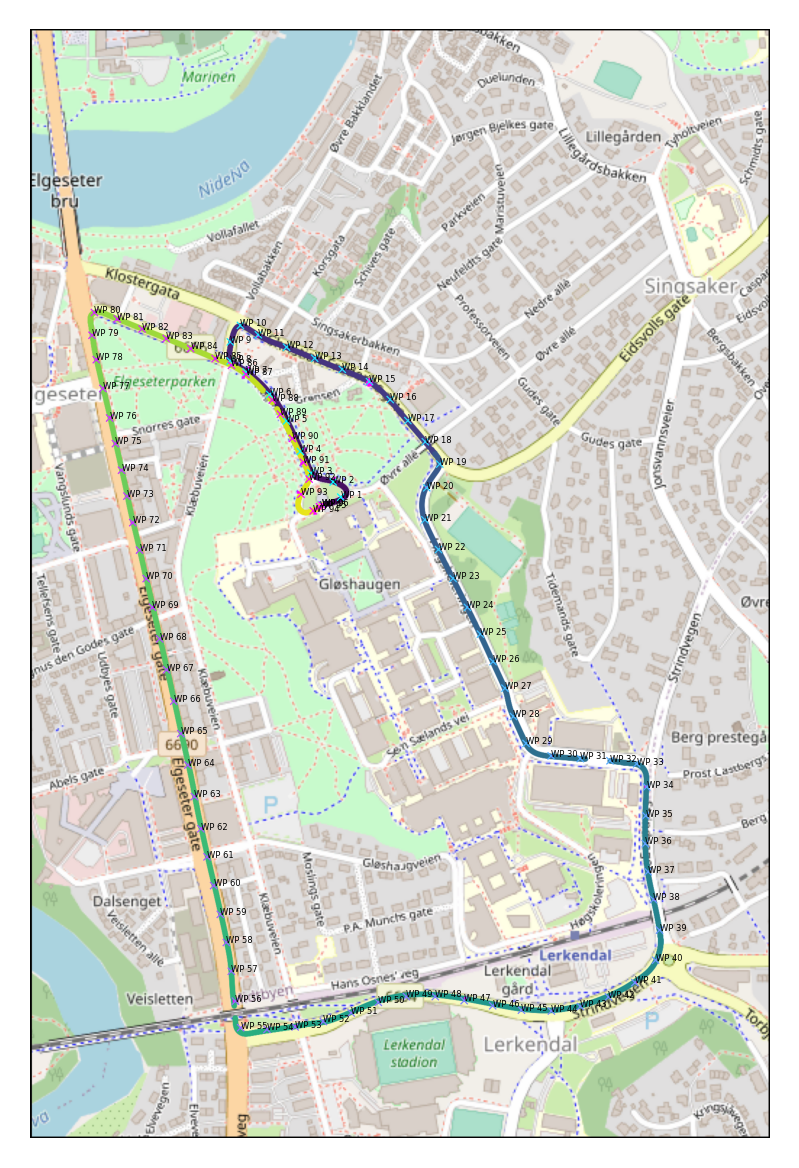

In [10]:
from matplotlib import pyplot as plt
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.imshow(image)
ax.set_axis_off()
ax.scatter(px_coords[iplan, 0], px_coords[iplan, 1], s=3, c=np.linspace(0, 1, len(iplan)), cmap='cool', marker='x', linewidths=0.3)
for i, idx in enumerate(iplan):
    ax.text(*px_coords[idx], f'WP {i}', fontsize=2)
fig.savefig('plan_annotated.png', dpi=600, bbox_inches='tight', pad_inches=0)

In [11]:
with open('plan.csv', 'wt') as csv:
    csv.write('idx,lat,lon,n,e,d,carla_lat,carla_lon\n')
    csv.writelines([
        f'-1,{gps_origin[0]},{gps_origin[1]},0,0,0,0,0\n'
    ])
    csv.writelines([
        f'{idx},{gps_coords[idx, 0]},{gps_coords[idx, 1]},{N[idx]},{E[idx]},{D[idx]},{carla_lat[idx]},{carla_lon[idx]}\n'
        for idx in iplan
    ])